# Manifold Learning (baseline for angle recovery from estimated distances)

In [26]:
import os
import h5py
from sklearn.neighbors import NearestNeighbors
import numpy as np   
from matplotlib import pyplot as plt
import ipyvolume as ipv
import seaborn as sns; sns.set(style="white", color_codes=True)
from time import time
import pandas as pd

import sys
sys.path.append("..") 
from cryoem.plots import plot_projection, plot_projections
from cryoem.projections import RotationMatrix

import tensorflow as tf
from tensorflow_graphics.util import asserts
from tensorflow_graphics.math import vector
from tensorflow_graphics.util import safe_ops
from tensorflow_graphics.util import shape
from tensorflow_graphics.geometry.transformation import quaternion, euler

In [2]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8397547314966876487
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6963548381195857733
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11685186230816921763
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3220635648
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1333450914764328762
physical_device_desc: "device: 0, name: GeForce GTX 1050 Ti with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


## Read generated data

Data was generated with:
```
python generator.py -mrc generated_data/bgal.mrc -num 5000
```

In [3]:
angle_ranges = "2.0,0.4,2.0"
angle_shift = "0.0,0.0,0.0"
n_samples = 5000
dir_name = "../data/"
projections_filename = f"5a1a_ProjectionsAngles_ProjNber{n_samples}_AngCoverage{angle_ranges}_AngShift{angle_shift}"


# load structures
data = h5py.File(os.path.join(dir_name, f"{projections_filename}.h5"), 'r')

#### With Rotation Matrix

In [4]:
all_vectors = RotationMatrix(data["Angles"])

ipv.figure(width=500, height=400)
ipv.scatter(all_vectors[:,0], all_vectors[:,2], all_vectors[:,1], marker="sphere", color="blue", size=1)
ipv.pylab.xlim(-1, 1)
ipv.pylab.ylim(-1, 1)
ipv.pylab.zlim(-1, 1)
ipv.show()

##### Angles

###### Predicted Angles

In [5]:
low_ang = [float(x)*np.pi for x in angle_shift.split(",")]
high_ang = [float(x)*np.pi for x in angle_ranges.split(",")]

euler = np.random.uniform(low=[low_ang[0], low_ang[1], low_ang[2]], 
                          high=[high_ang[0], high_ang[1], high_ang[2]],
                          size=(n_samples, 3))

angles_predicted = [tf.Variable(e) for e in euler]
print(f"Angles predicted: (min, max) = ({tf.reduce_min(angles_predicted):.4f}, {tf.reduce_max(angles_predicted):.4f})")

angles_predicted = np.array(angles_predicted)
angles_predicted.shape

Angles predicted: (min, max) = (0.0006, 6.2827)


(5000,)

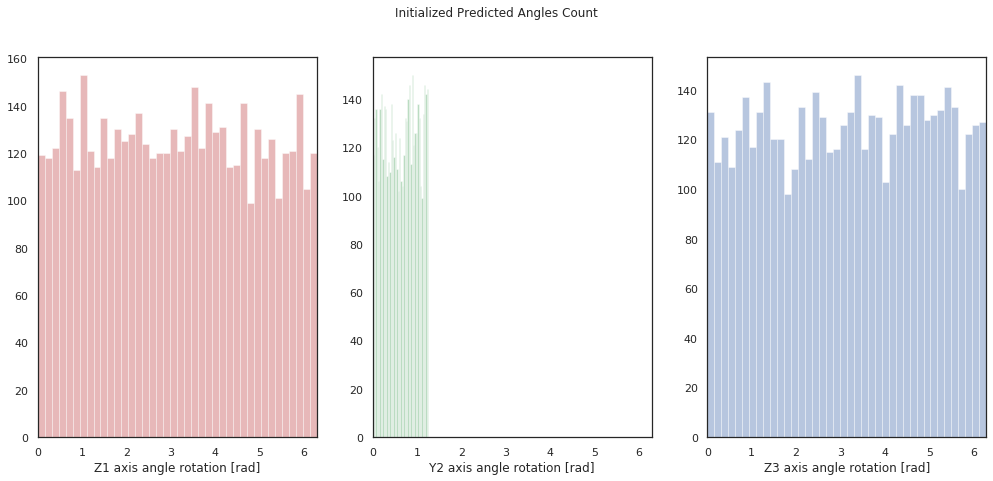

In [6]:
angles_predicted_plot = np.array([ np.array([(y%(2*np.pi)) for y in x.numpy()]) for x in angles_predicted])

fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,2*np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("Initialized Predicted Angles Count")

sns.distplot(angles_predicted_plot[:,0], kde=False, bins=40, ax=axs[0], axlabel="Z1 axis angle rotation [rad]", color="r")
sns.distplot(angles_predicted_plot[:,1], kde=False, bins=40, ax=axs[1], axlabel="Y2 axis angle rotation [rad]", color="g")
sns.distplot(angles_predicted_plot[:,2], kde=False, bins=40, ax=axs[2], axlabel="Z3 axis angle rotation [rad]", color="b");

###### True Angles

In [7]:
angles_true = np.reshape(data["Angles"], (data["Angles"].shape[0], -1))
print(f"Angles true: (min, max) = ({np.min(angles_true):.4f}, {np.max(angles_true):.4f})")

angles_true = np.array(angles_true)
angles_true.shape

Angles true: (min, max) = (0.0000, 6.2822)


(5000, 3)

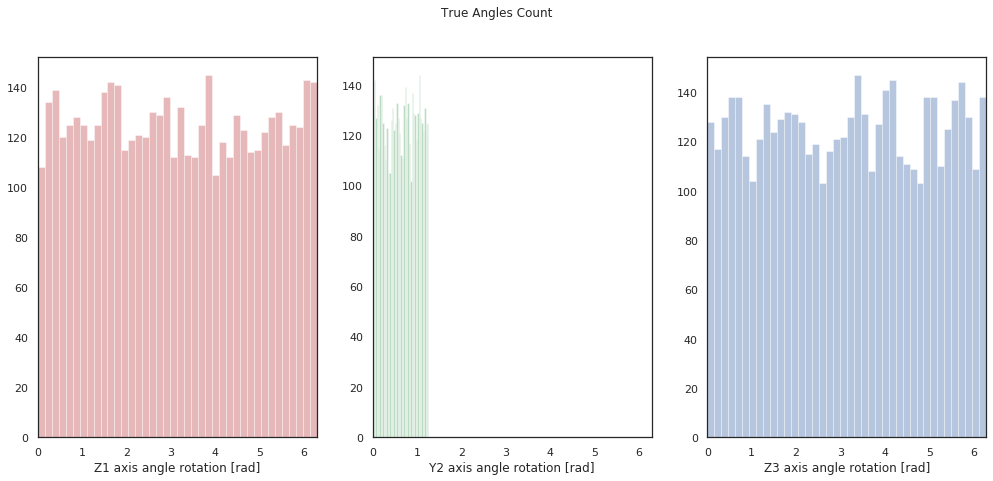

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,2*np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("True Angles Count")

sns.distplot(angles_true[:,0], kde=False, bins=40, ax=axs[0], axlabel="Z1 axis angle rotation [rad]", color="r")
sns.distplot(angles_true[:,1], kde=False, bins=40, ax=axs[1], axlabel="Y2 axis angle rotation [rad]", color="g")
sns.distplot(angles_true[:,2], kde=False, bins=40, ax=axs[2], axlabel="Z3 axis angle rotation [rad]", color="b");

##### Projections

In [9]:
projections = np.reshape(data["Projections"], (data["Projections"].shape[0], -1))
print(f"Projections: lenght = {len(projections)} (min, max) = ({np.min(projections):.4f}, {np.max(projections):.4f})")
projections = np.array(projections)

Projections: lenght = 5000 (min, max) = (0.0000, 74.5291)


---

## Manifold learning MDS

In [10]:
from sklearn.manifold import MDS

start_time = time.time()

embedding = MDS(n_components=4)
projections_MDS = embedding.fit_transform(projections)

print(f"--- {time.time() - start_time} seconds ---")

--- 456.69862699508667 seconds ---


In [11]:
print(projections_MDS.shape)
projections_MDS

(5000, 4)


array([[ 352.85596755,  478.68201037, -293.48979612, -552.18087459],
       [-810.443271  ,  114.59699694,  183.94736228, -312.73564195],
       [-412.14748794,  761.60737062, -170.3202295 ,  211.41877077],
       ...,
       [-180.6013641 ,  214.31161578,  282.50588972, -715.78956529],
       [1088.74546272,  144.00434347,  342.28856508,  334.6670653 ],
       [  -2.372068  ,  616.13912089,  356.28490086, -461.38693845]])

In [12]:
np.save(f'data/MDS_{projections_filename}_projections_MDS', projections_MDS) 

---

## Distances

##### Angle Distances

In [13]:
def euler2quaternion(angles):
    """
    Quaternion implements 3 rotations along x, y, z axis. 
    We compose them to get the final (single) rotation.
    """
    with tf.compat.v1.name_scope(None, "quaternion_from_euler", [angles]):
        #print(angles)
        a = [angles[i] for i in range(len(angles))]

        a = tf.convert_to_tensor(value=a)

        shape.check_static(tensor=a, tensor_name="angles", has_dim_equals=(-1, 3))

        half_angles = a / 2.0
        cos_half_angles = tf.cos(half_angles)
        sin_half_angles = tf.sin(half_angles)
        c1, c2, c3 = tf.unstack(cos_half_angles, axis=-1)
        s1, s2, s3 = tf.unstack(sin_half_angles, axis=-1)
        # Tait-Bryan angles
        #w = c1 * c2 * c3 + s1 * s2 * s3
        #x = -c1 * s2 * s3 + s1 * c2 * c3
        #y = c1 * s2 * c3 + s1 * c2 * s3
        #z = -s1 * s2 * c3 + c1 * c2 * s3
        
        # Euler angles
        w = c1*c2*c3 - s1*c2*s3
        x = c1*s2*s3 - s1*s2*c3
        y = c1*s2*c3 + s1*s2*s3
        z = c1*c2*s3 + s1*c2*c3
        return tf.stack((x, y, z, w), axis=-1)

def d_q(q1, q2):
     with (tf.compat.v1.name_scope(None, "quaternion_relative_angle",[q1, q2])):
        q1 = tf.convert_to_tensor(value=q1)
        q2 = tf.convert_to_tensor(value=q2)
      
        shape.check_static(
            tensor=q1, tensor_name="quaternion1", has_dim_equals=(-1, 4))
        shape.check_static(
            tensor=q2, tensor_name="quaternion2", has_dim_equals=(-1, 4))

        q1 = quaternion.normalize(q1)
        q2 = quaternion.normalize(q2)
        
        dot_product = vector.dot(q1, q2, keepdims=False)
        
        # Ensure dot product is in range [-1. 1].
        const = 1.8 #4.0 #.63
        eps_dot_prod = const * asserts.select_eps_for_addition(dot_product.dtype)
        dot_product = safe_ops.safe_shrink(
            dot_product, -1, 1, open_bounds=False, eps=eps_dot_prod)

        return 2.0 * tf.acos(tf.abs(dot_product)) 

In [14]:
assert tf.reduce_mean(d_q(euler2quaternion(angles_true[:,0:5]), euler2quaternion(angles_true[:,0:5]))) < 1e-7

In [15]:
assert tf.reduce_mean(d_q(euler2quaternion(angles_predicted[0:4]), euler2quaternion(angles_predicted[0:4]))) < 1e-7

In [16]:
assert (d_q(euler2quaternion([np.pi/2]*3), euler2quaternion([2*np.pi-np.pi/2]*3))-np.pi) < 1e-7

##### Projection Distance

In [17]:
def d_p(p1, p2):
    # (learned) distance between two images.
    # for now, Euclid dist
    p1 = tf.convert_to_tensor(value=p1, dtype=np.float64)
    p2 = tf.convert_to_tensor(value=p2, dtype=np.float64)

    if len(p1.shape) > 1:
        dist = tf.norm(p1-p2, ord='euclidean', axis=1, keepdims=True)
    else:
        dist = tf.norm(p1-p2, ord='euclidean')

    return dist

assert tf.reduce_mean(d_p(projections[0:3], projections[0:3])) < 1e-7

In [18]:
assert tf.reduce_mean(d_p(projections[0:3], projections[0:3])) < 1e-7
assert tf.reduce_mean(d_p(projections_MDS[0:3], projections_MDS[0:3])) < 1e-7

---

## dP vs dQ

#### Slope & Intercept from 1 compared to n

Collecting data for the plot where the result shows how 1 image changes distance in comparison to all the others. 

In [42]:
# Plot convergence.
all_q_dist = []
all_p_dist = []
time_start = time()

d_q_list = []
d_p_list = []

# Take the first image
i = 0

# Sample some pairs.
idx1 = list([i]*5000)
idx2 = list(range(5000))

# Compute distances between quaternions
a1 = [angles_true[i] for i in idx1]
a2 = [angles_true[i] for i in idx2]
q1 = euler2quaternion(a1)
q2 = euler2quaternion(a2)
distance_target_q = d_q(q1, q2)
d_q_list.append(distance_target_q)

# Compute distances between projections MDS
p1 = [projections_MDS[i] for i in idx1]
p2 = [projections_MDS[i] for i in idx2]
distance_target_p = d_p(p1, p2)
d_p_list.append(distance_target_p)

Text(0, 0.5, 'd_P')

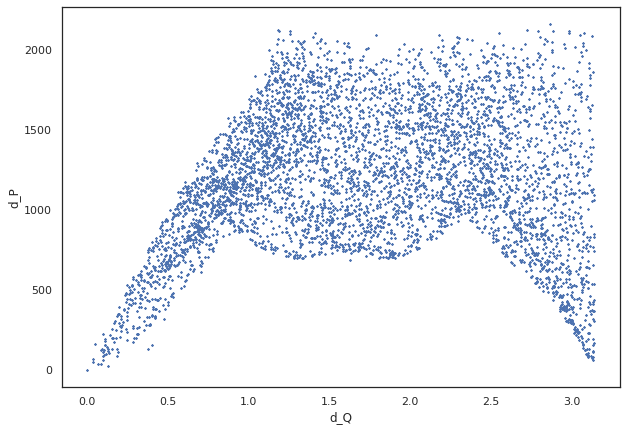

In [43]:
plt.figure(figsize=(10,7))
plt.plot(d_q_list[0], d_p_list[0], marker="*", markersize=2, lw=0)   
plt.xlabel('d_Q')
plt.ylabel('d_P')

In [56]:
# Creating the dataframe for SNS plot
data = {"d_Q" : list(d_q_list[0].numpy()),
        "d_P" : [x for x in d_p_list[0].numpy().T[0]]}
df = pd.DataFrame(data=data)
df = df[df.d_Q< 0.9];

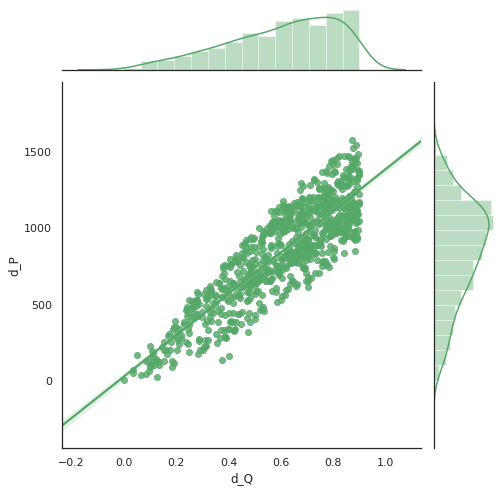

In [57]:
sns.jointplot(x="d_Q", y="d_P", data=df, kind="reg", color="g", height=7)  # "reg", "kde"

In [58]:
from scipy.stats import linregress
lr = linregress(df.d_Q, df.d_P)
slope, intercept = lr.slope, lr.intercept
print(f"d_P/d_Q = {slope}, intercept = {intercept}")

d_P/d_Q = 1361.768675704172, intercept = 24.582774582896718


###### Slope & Intercept from m to all n

Collecting data for the plot where the result shows how several images change (m=10) distance in comparison to all the others. 

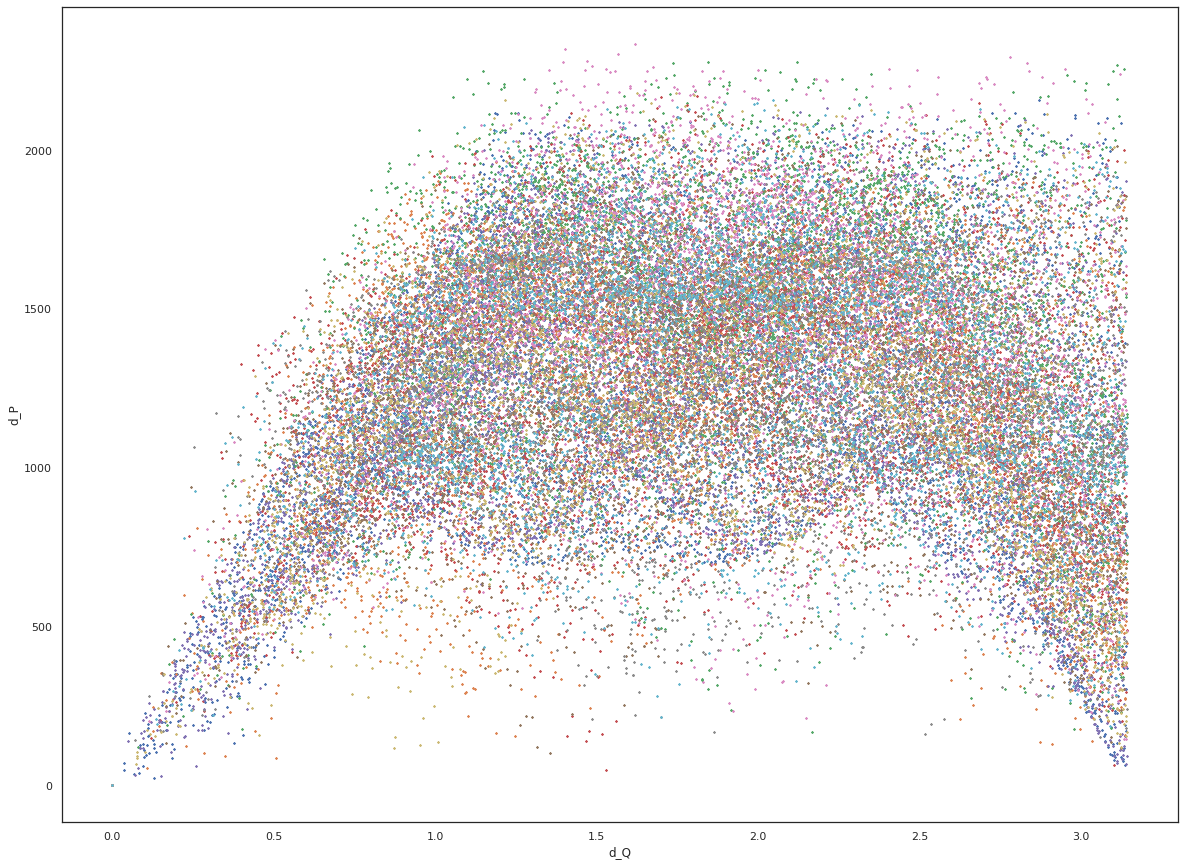

In [31]:
# Plot convergence.
all_q_dist = []
all_p_dist = []
time_start = time()

plt.figure(figsize=(20,15))

ITERATIONS = 5000

for i in range(0, ITERATIONS, 500):
    d_q_list = []
    d_p_list = []

    # Sample some pairs.
    idx1 = list([i]*5000)
    idx2 = list(range(5000))
    
    # Compute distances between quaternions
    a1 = [angles_true[i] for i in idx1]
    a2 = [angles_true[i] for i in idx2]
    q1 = euler2quaternion(a1)
    q2 = euler2quaternion(a2)
    distance_target_q = d_q(q1, q2)

    # Compute distances between projections
    p1 = [projections_MDS[i] for i in idx1]
    p2 = [projections_MDS[i] for i in idx2]
    distance_target_p = d_p(p1, p2)

    all_q_dist.extend([x.numpy() for x in distance_target_q])
    all_p_dist.extend([x.numpy()[0] for x in distance_target_p])
    
    plt.plot(distance_target_q, distance_target_p, marker="*", markersize=2, lw=0)
    
plt.xlabel('d_Q')
plt.ylabel('d_P');

In [32]:
# Creating the dataframe for SNS plot
data = {"d_Q" : all_q_dist,
        "d_P" : all_p_dist}
df = pd.DataFrame(data=data)

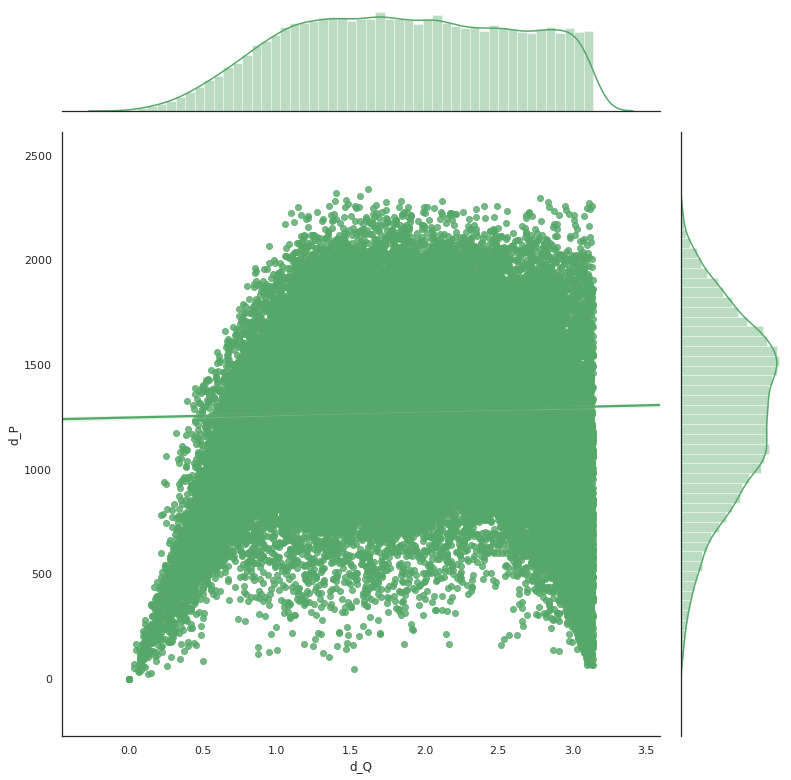

In [33]:
sns.jointplot(x="d_Q", y="d_P", data=df, kind="reg", color="g", height=11)  # "reg", "kde"

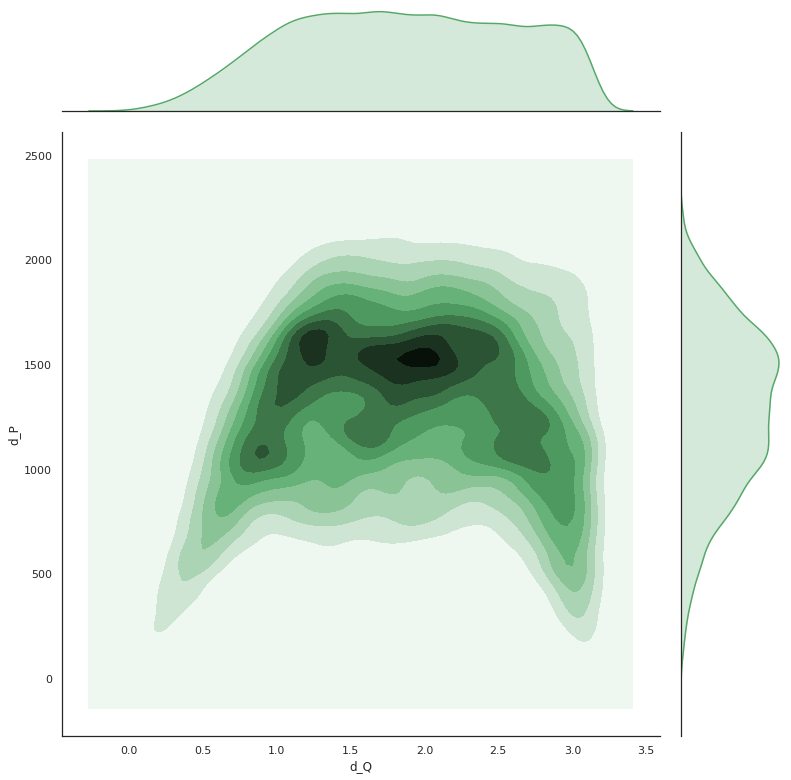

In [34]:
sns.jointplot(x="d_Q", y="d_P", data=df, kind="kde", color="g", height=11)

---

## Loss and gradient

Our goal is to then optimize
$$ \operatorname*{arg\,min}_{\{\hat{Q}_i\}_{i=1}^n} \sum_{\{i,j |d_p(p_i, p_j) < \epsilon\}} \left| d_p(p_i, p_j) - d_Q(\hat{Q}_i, \hat{Q}_j) \right|^2, $$
where $p_i$ is a projected image and $d_p$ is a (learned) distance between two images.

In [35]:
def loss(a1_predicted, a2_predicted, distance_target, dt_type, space):
    a1_predicted = list(a1_predicted)
    a2_predicted = list(a2_predicted)
    
    q1 = euler2quaternion(a1_predicted)
    q2 = euler2quaternion(a2_predicted)
    
    distance = d_q(q1, q2)
    
    if space == "dQspace":
        if dt_type == "dP":
            # Convert dP to dQ
            distance_target = (distance_target-intercept)/slope
            
    elif space == "dPspace":
        if dt_type == "dP":
            # Convert dQ to dP
            distance = tf.math.polyval(coeffs4dP, distance)
        elif dt_type == "dQ":
            distance = tf.math.polyval(coeffs4dP, distance)
            distance_target = tf.math.polyval(coeffs4dP, distance_target)  

    # The mean doesn't depend on the batch size.
    return tf.reduce_mean((distance - distance_target)**2)

In [36]:
def gradient(a1_predicted, a2_predicted, distance_target, dt_type, space):
    with tf.GradientTape() as tape:
        loss_value = loss(a1_predicted, a2_predicted, distance_target, dt_type, space)
        gradient = tape.gradient(loss_value, a1_predicted + a2_predicted)
        
    return loss_value, gradient

---

In [37]:
def loss_predicted_vs_true_angle(steps, batch_size, optimization=False):
    losses = np.empty(steps)
    time_start = time()
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    
    for step in range(1, steps+1):

        # Sample some pairs.
        idx1, idx2 = sample_pairs(n_samples, batch_size, style="random")
    
        a1 = [angles_predicted[i] for i in idx1]
        a2 = [angles_predicted[i] for i in idx2]

        # Compute distances between true quaternions
        a1_true = [angles_true[i] for i in idx1]
        a2_true = [angles_true[i] for i in idx2]
        q1_true = euler2quaternion(a1_true)
        q2_true = euler2quaternion(a2_true)
        
        distance_target = d_q(q1_true, q2_true)

        # Optimize by gradient descent.
        if optimization:
            losses[step-1], gradients = gradient(a1, a2, distance_target, dt_type="dQ", space="dQspace")
            optimizer.apply_gradients(zip(gradients, a1 + a2))
        else:
            losses[step-1] = loss(a1, a2, distance_target, dt_type="dQ", space="dQspace")
        
        # Periodically report progress.
        if ((step % (steps//10)) == 0) or (step == steps):
            time_elapsed = time() - time_start
            #loss_mean = np.mean(losses[(step-1)-(steps//10):step-1])
            print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')

    if optimization:
        # Plot convergence.
        fig, ax = plt.subplots()
        ax.plot(np.linspace(0, time()-time_start, steps), losses)
        ax.set_xlabel('time [s]')
        ax.set_ylabel('loss');
    else:
        print(f"Mean loss: {np.mean(losses)}")

In [38]:
def sample_pairs(n_samples, batch_size, style="random", k=None):
    if not k and style != "random":
        raise ValueError("Please specify k for kNN for sample_pairs method")
    
    if style=="random":
        idx1 = list(np.random.randint(0, n_samples, batch_size))
        idx2 = list(np.random.randint(0, n_samples, batch_size))
    
    elif style=="knn":
        idx1 = list(np.random.randint(0, n_samples, batch_size))
        indices_p, distances_p, A_p = get_knn_output(k=k)
        idx2 = [indices_p[i][np.random.randint(1, k)] for i in idx1]
 
    elif style=="knn_and_random":
        # select random sample for the first element of pair
        idx1 = list(np.random.randint(0, n_samples, batch_size))
        
        # half from kNN
        indices_p, distances_p, A_p = get_knn_output(k=k)
        idx2_knn = [indices_p[i][np.random.randint(1, k)] for i in idx1[:batch_size//2]]
        idx2_random = list(np.random.randint(0, n_samples, batch_size//2))
        # half random
        idx2 = idx2_knn + idx2_random
        
    return idx1, idx2

## Optimization loop (projection-true & angles-predict)

### [Before] Prediction vs. True Angles

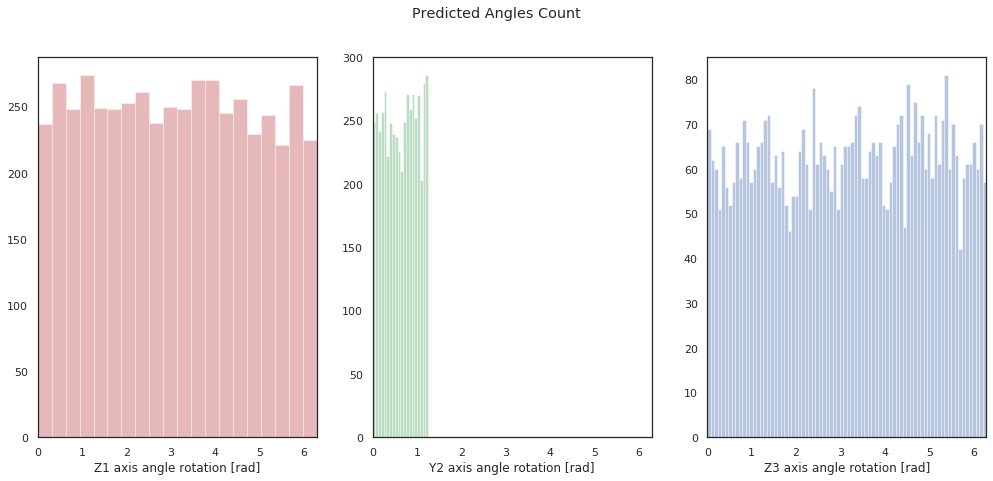

In [39]:
angles_predicted_plot = np.array([ np.array([(y%(2*np.pi)) for y in x.numpy()]) for x in angles_predicted])


fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,2*np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("Predicted Angles Count")

sns.distplot(angles_predicted_plot[:,0], kde=False, bins=20, ax=axs[0], axlabel="Z1 axis angle rotation [rad]", color="r")
sns.distplot(angles_predicted_plot[:,1], kde=False, bins=20, ax=axs[1], axlabel="Y2 axis angle rotation [rad]", color="g")
sns.distplot(angles_predicted_plot[:,2], kde=False, bins=80, ax=axs[2], axlabel="Z3 axis angle rotation [rad]", color="b");

In [40]:
loss_predicted_vs_true_angle(steps=2000, batch_size=256)

step 200/2000 (3s): loss = 1.14e+00
step 400/2000 (5s): loss = 1.18e+00
step 600/2000 (7s): loss = 1.19e+00
step 800/2000 (10s): loss = 9.68e-01
step 1000/2000 (12s): loss = 1.10e+00
step 1200/2000 (15s): loss = 1.05e+00
step 1400/2000 (17s): loss = 1.24e+00
step 1600/2000 (20s): loss = 1.12e+00
step 1800/2000 (22s): loss = 1.25e+00
step 2000/2000 (25s): loss = 1.14e+00
Mean loss: 1.0859558828134224


step 1000/10000 (100s): loss = 1.26e+00
step 2000/10000 (189s): loss = 1.46e+00
step 3000/10000 (278s): loss = 1.33e+00
step 4000/10000 (369s): loss = 1.28e+00
step 5000/10000 (458s): loss = 1.29e+00
step 6000/10000 (547s): loss = 1.38e+00
step 7000/10000 (636s): loss = 1.35e+00
step 8000/10000 (728s): loss = 1.29e+00
step 9000/10000 (817s): loss = 1.31e+00
step 10000/10000 (907s): loss = 1.15e+00


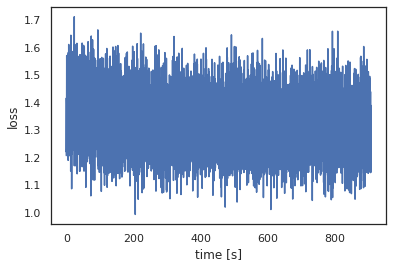

In [63]:
steps=10000
batch_size=256
lr = 0.001

#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

losses = np.empty(steps)
time_start = time()

for step in range(1, steps+1):

    # Sample some pairs.
    idx1, idx2 = sample_pairs(n_samples, batch_size, style="random")
    
    # Compute distances between projections
    p1 = [projections_MDS[i] for i in idx1]
    p2 = [projections_MDS[i] for i in idx2]
    
    distance_target = d_p(p1, p2)

    a1 = [angles_predicted[i] for i in idx1]
    a2 = [angles_predicted[i] for i in idx2]
    
    # Optimize by gradient descent.
    losses[step-1], gradients = gradient(a1, a2, distance_target, dt_type="dP", space="dQspace")
    optimizer.apply_gradients(zip(gradients, a1 + a2))

    # Periodically report progress.
    if ((step % (steps//10)) == 0) or (step == steps):
        time_elapsed = time() - time_start
        print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')

# Plot convergence.
fig, ax = plt.subplots()
ax.plot(np.linspace(0, time()-time_start, steps), losses)
ax.set_xlabel('time [s]')
ax.set_ylabel('loss');

### [After] Prediction vs. True Angles

In [64]:
loss_predicted_vs_true_angle(steps=2000, batch_size=256)

step 200/2000 (2s): loss = 1.40e+00
step 400/2000 (5s): loss = 1.32e+00
step 600/2000 (7s): loss = 1.48e+00
step 800/2000 (10s): loss = 1.19e+00
step 1000/2000 (12s): loss = 1.24e+00
step 1200/2000 (14s): loss = 1.29e+00
step 1400/2000 (17s): loss = 1.35e+00
step 1600/2000 (19s): loss = 1.24e+00
step 1800/2000 (22s): loss = 1.37e+00
step 2000/2000 (24s): loss = 1.32e+00
Mean loss: 1.3236297354729876


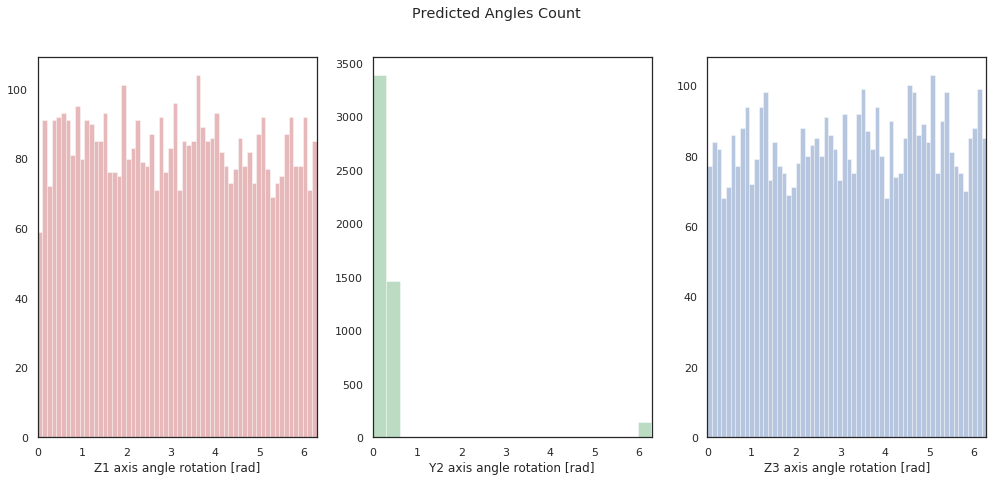

In [65]:
angles_predicted_plot = np.array([ np.array([(y%(2*np.pi)) for y in x.numpy()]) for x in angles_predicted])

fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,2*np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("Predicted Angles Count")

sns.distplot(angles_predicted_plot[:,0], kde=False, bins=60, ax=axs[0], axlabel="Z1 axis angle rotation [rad]", color="r")
sns.distplot(angles_predicted_plot[:,1], kde=False, bins=20, ax=axs[1], axlabel="Y2 axis angle rotation [rad]", color="g")
sns.distplot(angles_predicted_plot[:,2], kde=False, bins=60, ax=axs[2], axlabel="Z3 axis angle rotation [rad]", color="b");

In [66]:
# plot
all_vectors = RotationMatrix(angles_predicted_plot)
ipv.figure(width=500, height=500)
ipv.pylab.xlim(-1, 1)
ipv.pylab.ylim(-1, 1)
ipv.pylab.zlim(-1, 1)
ipv.scatter(all_vectors[:,0], all_vectors[:,2], all_vectors[:,1], marker="sphere", color="blue", size=1)
ipv.pylab.save(f"data/angle_variety/predicted_{lr}_{angle_ranges}.html")
ipv.show()